In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt 

def kMeans(X, K, maxIters = 20, plot_progress = None):

    centroids = X[np.random.choice(len(X), K)]
    for i in range(maxIters):
        # Cluster Assignment step
        C = np.array([np.argmin([(x_i-y_k)@(x_i-y_k) for y_k in centroids]) for x_i in X])
        # Update centroids step 
        centroids = []
        for k in range(K):
            if (C == k).any():
                centroids.append( X[C == k].mean(axis = 0) )
            else: # if there are no data points assigned to this certain centroid
                centroids.append( X[np.random.choice(len(X))] )
        if plot_progress != None: plot_progress(X, C, np.array(centroids))
    return np.array(centroids) , C

# def spikeSort()

        

4.1666666666666665e-05


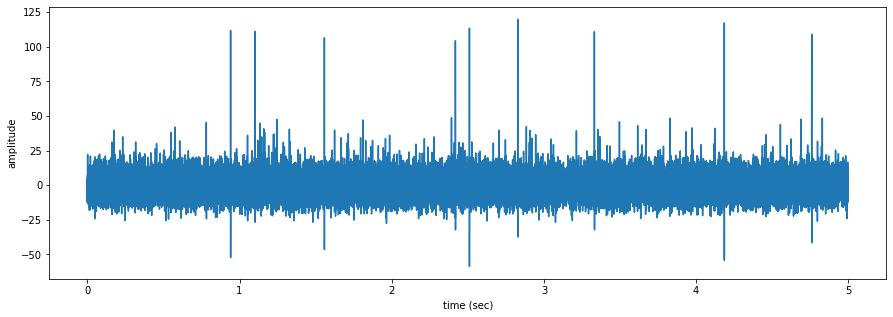

In [60]:
# load signal from file
file_in = loadmat("simulation_1.mat")

# uncomment this line for visibility
# print([key for key in file_in])

samplingInterval = file_in['samplingInterval'].item()/1000 # note: units in ms
startData = file_in['startData']
chan = file_in['chan']
data = file_in['data'].flatten()
spike_times = file_in['spike_times']
spike_class = file_in['spike_class']

# determine length of recording in seconds
duration = data.shape[0]*samplingInterval
t = np.linspace(0,duration,data.shape[0])
f_s = int(1/samplingInterval)
print(samplingInterval)

# display raw signal
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.plot(t[0:5*f_s], data[0:5*f_s])
ax.set_xlabel('time (sec)')
ax.set_ylabel('amplitude')
plt.show()

# Preprocessing raw data

In [56]:
from scipy.signal import butter, lfilter

# preprocess raw data by bandpass filtering 300-6000 Hz range using a 2nd order IIR bandpass filter (Butterworth)
b, a = butter(2, [300/(f_s/2), 6000/(f_s/2)], btype='band')
filtered_data = lfilter(b, a, data)

ValueError: Digital filter critical frequencies must be 0 < Wn < 1

In [ ]:
# determine a threshold to detect spikes



In [ ]:
# perform PCA to reduce dimensionality, extract features



In [ ]:
# use k-means to cluster spikes with similar characteristics